### EQNS FROM https://arxiv.org/pdf/2102.11248.pdf ONLY

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn
import h5py

In [2]:
ncpu = int(mul.cpu_count()*0.75)
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)

param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']

grb = 'GRB190114C'
# grb = 'GRB130925A'
grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = 12.5#grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m
lin_conv_fac = 3.0856 * 10**13
quad_conv_fac = 3.0856 * 10**7

In [3]:
grb

'GRB190114C'

In [4]:
#MODELS

#NULL model
def nullhp(E, alpha, tau):
    return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
    


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, alpha, tau):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (lin_conv_fac * e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

#QUADRATIC model
def quadhp(E, logEqg, alpha, tau):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (lin_conv_fac * e0qg * int_z2)/H0 + nullhp(E, alpha, tau)

In [5]:
#LOG-LIKELIHOODS
def loglike_null(theta):
    alpha, tau = theta
    
    
    model = nullhp(x,  alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    

def loglike_linear(theta):
    logEqg, alpha, tau = theta
    
    model = linearhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

def loglike_quad(theta):
    logEqg, alpha, tau = theta
    
    model = quadhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

In [6]:
#PRIORS
# 130925A
# alphamin = -2
# alphamax = 0.1
# taumin = -50
# taumax = 100
# logeqmin = 6
# logeqmax = 19


alphamin = -2
alphamax = 1
taumin = -20
taumax = 10
logeqmin = 0
logeqmax = 20

In [7]:
#PRIOR DISTRIBUTIONS

def prior_transform_null(theta):
    alpha, tau = theta
    return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_linear(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_quadratic(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

In [8]:
#SAMPLING
nlive = 1024

with dyn.pool.Pool(ncpu, loglike_null, prior_transform_null) as pool0:
    sampler0 = dyn.NestedSampler(loglike_null, prior_transform_null, ndim=2, nlive = nlive, sample='rwalk', bound='multi', pool=pool0)
    sampler0.run_nested(dlogz=0.01)
    # sampler0.save(os.getcwd() + '/outputs/sampler_saves/' + grbname_wtht_ext + '_null_sampler.dill', store_samples=True)

12587it [00:55, 228.66it/s, +1024 | bound: 58 | nc: 1 | ncall: 234646 | eff(%):  5.826 | loglstar:   -inf < -164.235 <    inf | logz: -171.911 +/-  0.078 | dlogz:  0.000 >  0.010]


In [9]:
with dyn.pool.Pool(ncpu, loglike_linear, prior_transform_linear) as pool1:
    sampler1 = dyn.NestedSampler(loglike_linear, prior_transform_linear, ndim=3, nlive = nlive, sample='rwalk', bound='multi', pool=pool1)
    sampler1.run_nested(dlogz=0.01)

17336it [01:21, 213.08it/s, +1024 | bound: 89 | nc: 1 | ncall: 353822 | eff(%):  5.204 | loglstar:   -inf < -3.048 <    inf | logz: -15.360 +/-    nan | dlogz:  0.000 >  0.010]  


In [10]:
with dyn.pool.Pool(ncpu, loglike_quad, prior_transform_quadratic) as pool2:
    sampler2 = dyn.NestedSampler(loglike_quad, prior_transform_quadratic, ndim=3, nlive = nlive, sample='rwalk', bound='multi', pool=pool2)
    sampler2.run_nested(dlogz=0.01)

18167it [01:24, 214.94it/s, +1024 | bound: 94 | nc: 1 | ncall: 373569 | eff(%):  5.151 | loglstar:   -inf < -48.707 <    inf | logz: -61.829 +/-    nan | dlogz:  0.000 >  0.010]


In [11]:
results0 = sampler0.results
results1 = sampler1.results
results2 = sampler2.results

In [12]:
def smooth_plot(results, figname, labels=["logE_qg", 'alpha', 'tau']):
        weights = np.exp(results.logwt - results.logz[-1])
        samples = dyn.utils.resample_equal(  results.samples, weights)
        
        fig = corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
        ndim =samples.shape[1]
        for axidx, samps in zip([i*(ndim+1) for i in range(ndim)],samples.T):
            kde = gaussian_kde(samps)
            xvals = fig.axes[axidx].get_xlim()
            xvals = np.linspace(xvals[0], xvals[1], 100)
            fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
            
        # plt.title(str(grb) + '\n\n')
        plt.suptitle(str(grb) + '\n\n', x=0.75, y=0.75)
        plt.savefig(os.getcwd() + '/outputs/contours/' + grb + '_' + figname + '.png')
        plt.show()

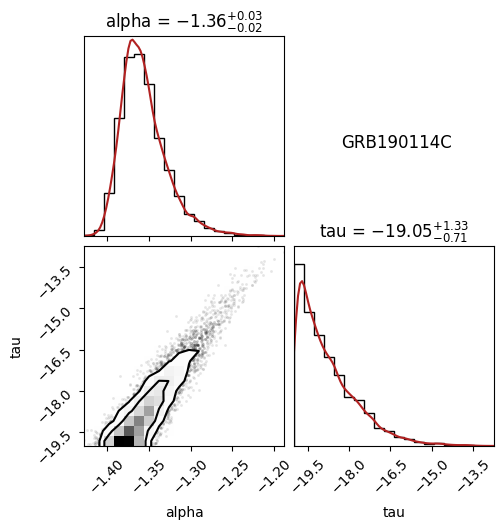

In [13]:
smooth_plot(results0, 'nullhp', labels=["alpha", 'tau'])

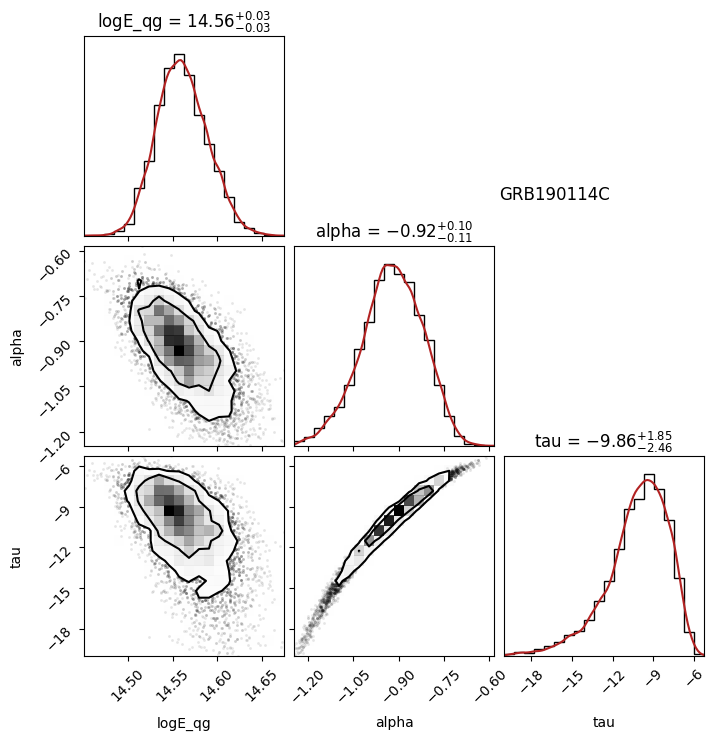

In [14]:
smooth_plot(results1, 'linearhp')

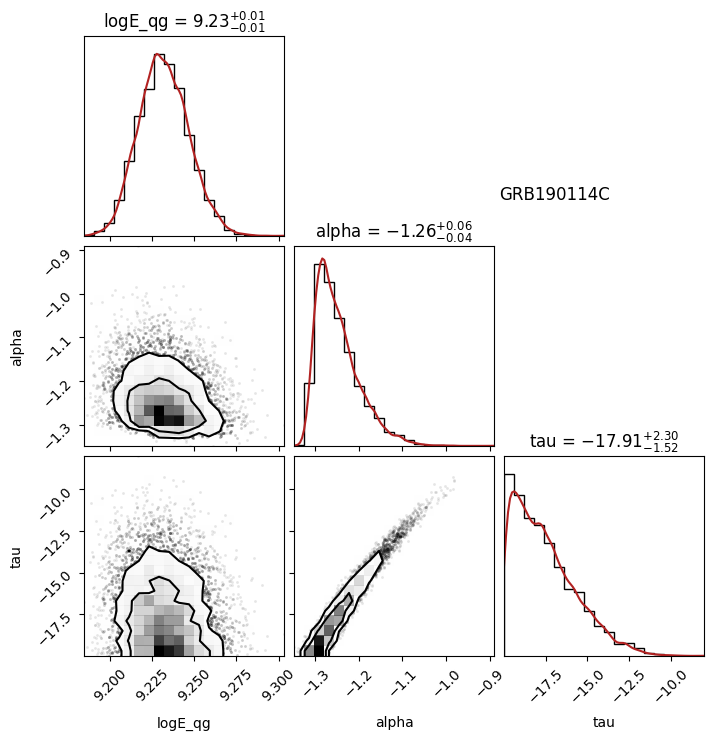

In [15]:
smooth_plot(results2, 'quadhp')

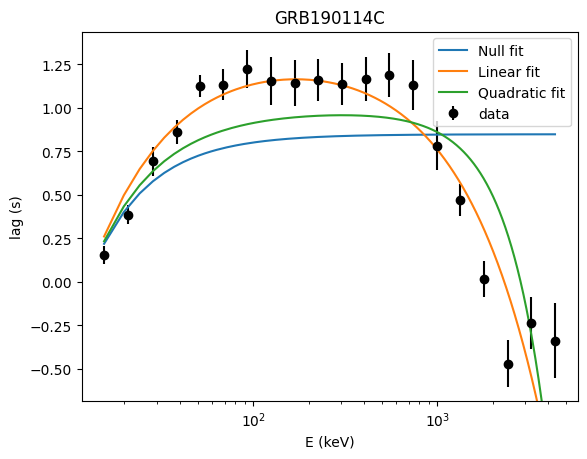

Bayes factor for null model:  -171.910697483253 +/- 0.08103194621494535
Bayes factor for linear LIV model:  -15.35960683056116 +/- 0.10570910833509405
Bayes factor for quadratic LIV model:  -61.829405658804355 +/- 0.10932092373012181


In [16]:
#PLOTTING FITS

nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0 = samples0[np.argmax(results0.logl)]

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1 = samples1[np.argmax(results1.logl)]

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2 = samples2[np.argmax(results2.logl)]
null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
liv_quad_fit = [quadhp(E[i], samples2[0], samples2[1], samples2[2]) for i in range(nplot)]

plt.errorbar(x, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit, label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit')
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grbname_wtht_ext)
plt.savefig(os.getcwd() + '/outputs/fits/' + grbname_wtht_ext + '_fit_logE.png', facecolor='white')
plt.show()

# bayes_factor_lin = np.exp(results1.logz[-1] - results0.logz[-1])
# bayes_factor_quad = np.exp(results2.logz[-1] - results0.logz[-1])

print('Bayes factor for null model: ', results0.logz[-1], '+/-', results0.logzerr[-1])
print('Bayes factor for linear LIV model: ', results1.logz[-1], '+/-', results1.logzerr[-1])
print('Bayes factor for quadratic LIV model: ', results2.logz[-1], '+/-', results2.logzerr[-1])

with open('outputs/BF/' + grb + '_results.txt', 'w') as f:
    f.write(str(results0.logz[-1]) + ',' + str(results0.logzerr[-1]) + '\n')
    f.write(str(results1.logz[-1]) + ',' + str(results1.logzerr[-1]) + '\n')
    f.write(str(results2.logz[-1]) + ',' + str(results2.logzerr[-1]) + '\n')
    
f.close()
f = []

In [17]:
dyn.utils.save_sampler(sampler0, 'outputs/sampler_saves/' + grb + '_null_sampler.pkl')
dyn.utils.save_sampler(sampler1, 'outputs/sampler_saves/' + grb + '_linear_sampler.pkl')
dyn.utils.save_sampler(sampler2, 'outputs/sampler_saves/' + grb + '_quadratic_sampler.pkl')

In [18]:
def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
    print(len(y) - len(fit_func_args))
    return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))

In [19]:
gof_null = chi2_gof(x, y, yerr, nullhp, samples0[0], samples0[1])
gof_lin = chi2_gof(x, y, yerr, linearhp, samples1[0], samples1[1], samples1[2])
gof_quad = chi2_gof(x, y, yerr, quadhp, samples2[0], samples2[1], samples2[2])


with open('outputs/GOF/' + grb + '_GOF.txt', 'w') as f:
    f.write(str(gof_null) + '\n')
    f.write(str(gof_lin) + '\n')
    f.write(str(gof_quad) + '\n')
    
f.close()
f = []

18
17
17


In [20]:
print('GOF for null model: ', gof_null)
print('GOF for linear LIV model: ', gof_lin)
print('GOF for quadratic LIV model: ', gof_quad)

GOF for null model:  21.231404460796483
GOF for linear LIV model:  3.571564909328978
GOF for quadratic LIV model:  9.346086139228293
